In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
from scipy import stats
from scipy.stats import norm, skew #for some statistics
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Models
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet, Lasso, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

#Gridsearch
from sklearn.model_selection import GridSearchCV

Support for cell alignment in markdown table

In [2]:
%%javascript
var marked = require('components/marked/lib/marked');

if (marked.Renderer.name !== 'NonExtensibleTableRenderer') {
    function tablecell(content, flags) {
        var type = flags.header ? 'th' : 'td';
        var style = flags.align == null ? '' : ' style="text-align: ' + flags.align + '"';
        var start_tag = '<' + type + style + '>';
        var end_tag = '</' + type + '>\n';
        return start_tag + content + end_tag;
    }

    var DefaultRenderer = marked.Renderer;
    function NonExtensibleTableRenderer(options) {
        DefaultRenderer.call(this, options);
        Object.defineProperty(this, 'tablecell', {
            get: function () { return tablecell; },
            set: function () { } // No-op, sorry for this hack but we must prevent it from being redefined
        });
    }
    NonExtensibleTableRenderer.prototype = Object.create(DefaultRenderer.prototype);
    NonExtensibleTableRenderer.prototype.constructor = NonExtensibleTableRenderer;

    marked.setOptions({
        renderer: new NonExtensibleTableRenderer()
    });
    // Look away... it has to be done as newer versions of the notebook build a custom
    // renderer rather than extending the default.
    marked.Renderer = NonExtensibleTableRenderer;
}

var Jupyter = require('base/js/namespace');
Jupyter.notebook.get_cells()
   .filter(cell => cell.cell_type === 'markdown' && cell.rendered)
   .forEach(mdcell => {
       mdcell.unrender();
       mdcell.render();
   });

<IPython.core.display.Javascript object>

# Project Overview
A home is probably the most expensive purchase that a person will do in his or her lifetime. The most important constraint while buying a home is the value of the property. So, a good model that can predict the value of the property will help users to shortlist and buy their dream property. 
Also, with increasing population and urbanization this model can help various stakeholders involved in the planning, construction and expansion of towns and cities.

# Problem Statement
Here I try to build a model for [Ames Housing dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) to predict the hosue price using Regression Techniques.<br/>

We will follow the following steps to build our model
1. Exploratory data analysis of the data
2. Data cleaning - Missing data
3. Categorical Features - Encoding and Dummies
4. Numerical Features - Normality, Skewness and Kurtosis
5. Baseline models pipelines
6. Grid Search for best parameters for top three baseline models
7. Stacked models combining top three models

# Metrics

I will evalute the models on the basis of Root-Mean-Squared-Error between the logarithm of the predicted value and the logarithm of the observed sales price (RMSLE). Taking logs will ensure that errors in predicting expensive houses and cheap houses will affect the result equally.
<br/>

This measurement is useful when there is a wide range in the target variable, and you do not necessarily want to penalize large errors when the predicted and target values are themselves high. It is also effective when we care about percentage errors rather than the absolute value of errors.

In [3]:
'''Importing data'''
all_data = pd.read_csv('./data/train.csv')

# Data Exploration and Data Visualization

In [4]:
all_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
all_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
print(all_data.shape)

(1460, 81)


### Target Feature
SalePrice is the variable we need to predict. So let's do some analysis on this variable first.


 mu = 180921.20 and sigma = 79415.29



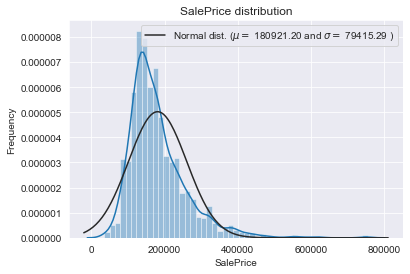

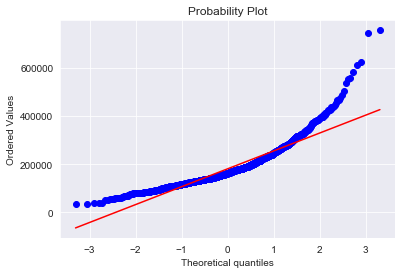

In [7]:
sns.distplot(all_data['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(all_data['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(all_data['SalePrice'], plot=plt)
plt.show()

* Deviate from the normal distribution.
* Have appreciable positive skewness.
* Show peakedness.

In [8]:
'''skewness and kurtosis'''
print("Skewness: %f" % all_data['SalePrice'].skew())
print("Kurtosis: %f" % all_data['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


As the distribution is skewed we have to trasform it such that it follows a normal distribution.
<br/>
We can use different transformations to achieve this such as
1. Log Transformation
2. [Box Cox Transformation](https://www.statisticshowto.datasciencecentral.com/box-cox-transformation/) - Requires estimation of lambda parameter
3. Square Root Trasformation

Here we will go with the Log Transformations to trasform and normalize skewed features


 mu = 12.02 and sigma = 0.40



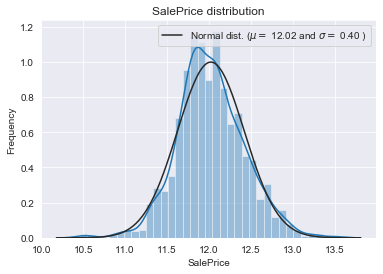

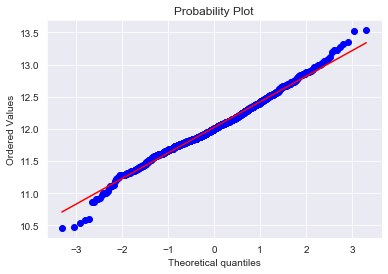

In [9]:
all_data["SalePrice"] = np.log1p(all_data["SalePrice"])

#Check the new distribution 
sns.distplot(all_data['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(all_data['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(all_data['SalePrice'], plot=plt)
plt.show()

In [10]:
'''skewness and kurtosis'''
print("Skewness: %f" % all_data['SalePrice'].skew())
print("Kurtosis: %f" % all_data['SalePrice'].kurt())

Skewness: 0.121347
Kurtosis: 0.809519


### Missing Data 

In [11]:
'''Get missing data features and sort them by amount of missing values'''
all_data_na = all_data.isnull().sum()
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Values' :all_data_na})
missing_data

,Missing Values
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
FireplaceQu,690
LotFrontage,259
GarageYrBlt,81
GarageType,81
GarageFinish,81
GarageQual,81


Text(0.5, 1.0, 'Percent missing data by feature')

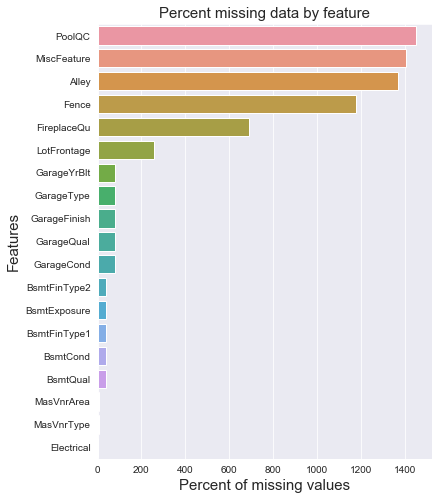

In [12]:
f, ax = plt.subplots(figsize=(6, 8))
sns.barplot(x=all_data_na, y=all_data_na.index)
plt.ylabel('Features', fontsize=15)
plt.xlabel('Total of missing values', fontsize=15)
plt.title('Missing data by feature', fontsize=15)

# Data Preprocessing

### Missing Features

| Missing Feature	| Description| Remarks  	|
|:------------------|:----------|:------------|
|   PoolQC	    |   NA means "No Pool"      	|   No need to drop. Replace with None	|
|   MiscFeature	|   NA means "no misc feature"	|   No need to drop. Replace with None	|
|   Alley    	|   NA means "no alley access"	|   No need to drop. Replace with None	|
|   Fence   	|   NA means "no fence"     	|   No need to drop. Replace with None	|
|   FireplaceQu	|   NA means "no fireplace"  	|   No need to drop. Replace with None	|
|   LotFrontage	|   Data not available      	|   Can be replaced with median	|
|   GarageYrBlt	|   NA indicate no garage   	|   No need to drop. Replace with None	|
|   GarageType	|   NA indicate no garage   	|   No need to drop. Replace with None	|
|   GarageFinish|   NA indicate no garage   	|   No need to drop. Replace with None	|
|   GarageQual	|   NA indicate no garage   	|   No need to drop. Replace with None	|
|   GarageCond	|   NA indicate no garage   	|   No need to drop. Replace with None	|
|   BsmtFinType2|   NaN means no basement   	|   No need to drop. Replace with None	|
|   BsmtExposure|   NaN means no basement   	|   No need to drop. Replace with None	|
|   BsmtFinType1|   NaN means no basement   	|   No need to drop. Replace with None	|
|   BsmtCond	|   NaN means no basement   	|   No need to drop. Replace with None	|
|   BsmtQual	|   NaN means no basement   	|   No need to drop. Replace with None	|
|   MasVnrArea	|   NA means no masonry veneer	|   Replace with 0	|
|   MasVnrType	|   NA means no masonry veneer	|   No need to drop. Replace with None	| 
|   Electrical	|   Only one missing value  	|   Replace with most frequent value 'SBrkr'	|

In [13]:
'''Clean the missing data as per the strategy described'''
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data["LotFrontage"].fillna(all_data["LotFrontage"].median())
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna('None')
all_data['GarageType'] = all_data['GarageType'].fillna('None')
all_data['GarageFinish'] = all_data['GarageFinish'].fillna('None')
all_data['GarageQual'] = all_data['GarageQual'].fillna('None')
all_data['GarageCond'] = all_data['GarageCond'].fillna('None')
all_data['BsmtFinType2'] = all_data['BsmtFinType2'].fillna('None')
all_data['BsmtExposure'] = all_data['BsmtExposure'].fillna('None')
all_data['BsmtFinType1'] = all_data['BsmtFinType1'].fillna('None')
all_data['BsmtCond'] = all_data['BsmtCond'].fillna('None')
all_data['BsmtQual'] = all_data['BsmtQual'].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [14]:
'''Check remaining missing values if any'''
all_data_na = all_data.isnull().sum()
len(all_data_na[all_data_na != 0])

0

### Numerical Features 

In [15]:
'''Types of features'''
all_data.dtypes.value_counts()

object     44
int64      34
float64     3
dtype: int64

In [16]:
'''Numerical features'''
numerical_features = list(all_data.dtypes[all_data.dtypes != 'object'].index.drop('Id'))

Check for features with high skew and kurtosis

In [17]:
skew = all_data[numerical_features].apply(lambda feature: feature.skew(), axis=0)
kurt = all_data[numerical_features].apply(lambda feature: feature.kurt(), axis=0)
skew_kurt = pd.concat([skew, kurt], axis=1)
skew_kurt.shape

(36, 2)

In [18]:
skew_kurt.sort_values([0], ascending=[False])

,0,1
MiscVal,24.477,701.003
PoolArea,14.828,223.268
LotArea,12.208,203.243
3SsnPorch,10.304,123.662
LowQualFinSF,9.011,83.235
KitchenAbvGr,4.488,21.532
BsmtFinSF2,4.255,20.113
ScreenPorch,4.122,18.439
BsmtHalfBath,4.103,16.397
EnclosedPorch,3.090,10.431


In [19]:
highly_skewed_features = skew_kurt.loc[abs(skew_kurt[0]) > 0.75].index
highly_skewed_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [20]:
'''Log Transform highly skewed features'''
for feature in highly_skewed_features:
    all_data[feature] = np.log1p(all_data[feature])

### Categorical Features

In [21]:
'''Find categorical features'''
'''Considering all features having less than 50 unique values as categorical features'''
feature_unique_count = pd.Series()
all_data.apply(lambda feature: feature_unique_count.set_value(feature.name, len(feature.value_counts())), axis=0)
categorical_features = feature_unique_count[feature_unique_count <= 50].index
categorical_features

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual',
       'GarageCond', 'PavedDrive', '3SsnPorch', 'PoolArea', 'PoolQC', 'Fence',
       'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [22]:
'''Convert categorical features to strings'''
for feature in categorical_features:
    all_data[feature] = all_data[feature].astype(str)

In [24]:
all_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,4.110873864173311,RL,4.190,9.042,Pave,None,Reg,Lvl,AllPub,...,0.0,None,None,None,0.0,2,2008,WD,Normal,12.248
1,2,3.044522437723423,RL,4.394,9.170,Pave,None,Reg,Lvl,AllPub,...,0.0,None,None,None,0.0,5,2007,WD,Normal,12.109
2,3,4.110873864173311,RL,4.234,9.328,Pave,None,IR1,Lvl,AllPub,...,0.0,None,None,None,0.0,9,2008,WD,Normal,12.317
3,4,4.2626798770413155,RL,4.111,9.164,Pave,None,IR1,Lvl,AllPub,...,0.0,None,None,None,0.0,2,2006,WD,Abnorml,11.849
4,5,4.110873864173311,RL,4.443,9.565,Pave,None,IR1,Lvl,AllPub,...,0.0,None,None,None,0.0,12,2008,WD,Normal,12.429


In [25]:
all_data.shape

(1460, 81)

In [26]:
'''Get dummy variables'''
all_data = pd.get_dummies(all_data)

In [27]:
list(all_data.columns)

['Id',
 'LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch',
 'SalePrice',
 'MSSubClass_3.044522437723423',
 'MSSubClass_3.4339872044851463',
 'MSSubClass_3.713572066704308',
 'MSSubClass_3.828641396489095',
 'MSSubClass_3.9318256327243257',
 'MSSubClass_4.110873864173311',
 'MSSubClass_4.2626798770413155',
 'MSSubClass_4.330733340286331',
 'MSSubClass_4.394449154672439',
 'MSSubClass_4.454347296253507',
 'MSSubClass_4.51085950651685',
 'MSSubClass_4.795790545596741',
 'MSSubClass_5.081404364984463',
 'MSSubClass_5.198497031265826',
 'MSSubClass_5.25227342804663',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Grvl',
 'Street_Pave',
 'Alley_Grvl',
 'Alley_None',
 'Alley_Pave',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',

In [28]:
all_data.shape

(1460, 554)

# Model Implementation

* Lets build some baseline model pipelins and see their performance.
* We will use MinMaxScaler as our feature scaler in the pipelines

In [29]:
all_data.columns

Index(['Id', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=554)

In [30]:
all_data.head()

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,4.190,9.042,2003,2003,5.283,6.561,0.000,5.017,6.753,...,0,0,0,1,0,0,0,0,1,0
1,2,4.394,9.170,1976,1976,0.000,6.887,0.000,5.652,7.141,...,0,0,0,1,0,0,0,0,1,0
2,3,4.234,9.328,2001,2002,5.094,6.188,0.000,6.075,6.825,...,0,0,0,1,0,0,0,0,1,0
3,4,4.111,9.164,1915,1970,0.000,5.380,0.000,6.293,6.629,...,0,0,0,1,1,0,0,0,0,0
4,5,4.443,9.565,2000,2000,5.861,6.486,0.000,6.196,7.044,...,0,0,0,1,0,0,0,0,1,0


### Validation Strategy

In [31]:
all_features = all_data.columns.drop(['Id','SalePrice'])
train  = all_data[all_features].to_numpy()
target = all_data['SalePrice'].to_numpy().reshape(-1,1)

In [32]:
'''KFolds Cross Validation'''
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train)
    rmse= np.sqrt(-cross_val_score(model, train, target, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [33]:
'''Creating Pipelines'''
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
lasso  = make_pipeline(MinMaxScaler(), Lasso())
ENet   = make_pipeline(MinMaxScaler(), ElasticNet())
LaLasso= make_pipeline(MinMaxScaler(), LassoLarsIC())
KRR    = make_pipeline(MinMaxScaler(), KernelRidge())
GBoost = make_pipeline(MinMaxScaler(), GradientBoostingRegressor())
model_xgb = make_pipeline(MinMaxScaler(), xgb.XGBRegressor())
model_lgb = make_pipeline(MinMaxScaler(), lgb.LGBMRegressor())
random_forest = make_pipeline(MinMaxScaler(), RandomForestRegressor())

In [34]:
'''Get the validations scores for all pipelines'''
kfold_scores = pd.Series()
score = rmsle_cv(lasso)
kfold_scores.set_value('Lasso', score.mean())
score = rmsle_cv(ENet)
kfold_scores.set_value('Enet', score.mean())
score = rmsle_cv(LaLasso)
kfold_scores.set_value('LaLasso', score.mean())
score = rmsle_cv(KRR)
kfold_scores.set_value('KRR', score.mean())
score = rmsle_cv(GBoost)
kfold_scores.set_value('GBoost', score.mean())
score = rmsle_cv(model_xgb)
kfold_scores.set_value('XGB', score.mean())
score = rmsle_cv(model_lgb)
kfold_scores.set_value('LGB', score.mean())
score = rmsle_cv(random_forest)
kfold_scores.set_value('Random_Forest', score.mean())

[16:48:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:48:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Lasso           0.399
Enet            0.399
LaLasso         0.153
KRR             0.153
GBoost          0.133
XGB             0.135
LGB             0.138
Random_Forest   0.154
dtype: float64

In [35]:
'''Sorting from lowest error to highest'''
kfold_scores.sort_values(ascending=True)

GBoost          0.133
XGB             0.135
LGB             0.138
KRR             0.153
LaLasso         0.153
Random_Forest   0.154
Lasso           0.399
Enet            0.399
dtype: float64

# Refinement

* Grid Search for best baseline models.
* Top three baseline models are - GBoost, XGB and LGB

In [36]:
'''Default GradientBoostingRegressor Parameters'''
GradientBoostingRegressor().get_params()

{'alpha': 0.9,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [37]:
param_grid={
            'n_estimators':[50,75,100], 
            'max_depth':[3,4,5], 
            'min_samples_leaf':[1,3,5]
}
CV_rfc = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=param_grid, cv= 5)
CV_rfc.fit(train, target)
print(CV_rfc.best_params_)

{'max_depth': 4, 'min_samples_leaf': 3, 'n_estimators': 100}


In [38]:
xgb.XGBRegressor().get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [39]:
param_grid={
            'learning_rate': [0.1, 0.05, 0.02],
            'n_estimators': [50,100,150],
            'max_depth': [3,5,10],
            'objective': ['reg:squarederror']
}
CV_rfc = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=param_grid, cv= 5)
CV_rfc.fit(train, target)
print(CV_rfc.best_params_)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'objective': 'reg:squarederror'}


In [40]:
lgb.LGBMRegressor().get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [41]:
param_grid={
            'learning_rate': [0.1, 0.05, 0.02],
            'n_estimators': [50,100,150],
            'num_leaves': [20,31,40]
}
CV_rfc = GridSearchCV(estimator=lgb.LGBMRegressor(), param_grid=param_grid, cv= 5)
CV_rfc.fit(train, target)
print(CV_rfc.best_params_)

{'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 20}


In [42]:
optimized_kfold_scores = pd.Series()
opt_GBoost = make_pipeline(MinMaxScaler(), GradientBoostingRegressor(max_depth=4, min_samples_leaf=3, n_estimators=100))
opt_model_xgb = make_pipeline(MinMaxScaler(), xgb.XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=150, objective='reg:squarederror'))
opt_model_lgb = make_pipeline(MinMaxScaler(), lgb.LGBMRegressor(learning_rate=0.1, n_estimators=150, num_leaves=20))
score = rmsle_cv(opt_GBoost)
optimized_kfold_scores.set_value('GBoost', score.mean())
score = rmsle_cv(opt_model_xgb)
optimized_kfold_scores.set_value('XGB', score.mean())
score = rmsle_cv(opt_model_lgb)
optimized_kfold_scores.set_value('LGB', score.mean())

GBoost   0.132
XGB      0.130
LGB      0.134
dtype: float64

* With a basic grid search we are able to improve the metirc of all three models.
* The metrics was imporved mos tin the XGB model.


# Model Evaluation and Validation

Lets build the final model by stacking the top three tuned baseline models

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
class StackedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [44]:
GBoost = GradientBoostingRegressor(max_depth=4, min_samples_leaf=3, n_estimators=100)
XGB    = xgb.XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=150, objective='reg:squarederror')
LGB    = lgb.LGBMRegressor(learning_rate=0.1, n_estimators=150, num_leaves=20)
stacked_models = make_pipeline(MinMaxScaler(), StackedModels(models = [GBoost, XGB, LGB]))
score = rmsle_cv(stacked_models)
score.mean()

0.1271967491568746

# Results and Justification

With the stacked model we achieved an even better metric score. Please note that error metric is RMSLE and hence the reduction in error of real price will be an exponential factor of this error reduction.
<br/>
With the above models we have achieved the following goals:
1. Successfully analyzed, cleaned and scaled our dataset.
2. Build Baseline models to investigate our metric of concern, i.e, Root Mean Square Log Error (RMSLE)
3. Using gridsearch and model stacking for new model (RMSLE 0.127), achieved error reduction of 0.006 compared to the best baseline model (GBoost RMSLE 0.133)


# Reflections and Improvement

Our model gives us a pretty good score based on our metrics.
<br/>
However, there is more scope for fine tuning and improvemnt of the model:
1. We have used Log Transformation to normalize skewed features in our dataset. Sometimes a Box Cox Transformation will work better for normalization. However, the Box Cox Transformation requires estimation its lambda values as input parameter. Better normalized ata will increase the scope for reduction of error and improvement of our RMSLE metric.
2. We have done grid search on some important and basic parmeters. We found that using tuned paramters for our pipeline decreses our error. However, given more computing power, a better more exhaustive grid search can be done to further fine tune the model and reduce the error.
3. We can use different stacking strategies, such as weighted stacking and add more tuned baseline models to our stack list to reduce our error

Finally, we saw that stacking and using combined models can significantly reduce our error and improve our model and final predictions.